# Resnet18

## 1 Letter Recognition

### 1.1 Model training

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Get the working directory where the dataset is located
woking_dir = '../input'

# Check the working directory
# You should see the datasets
os.listdir(woking_dir)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['asl-alphabet', 'asl-alphabet-test']

In [2]:
# Check the directory of the test dataset
path_to_train = os.path.join(woking_dir, 'asl-alphabet', 'asl_alphabet_train', 'asl_alphabet_train')
path_to_test = os.path.join(woking_dir, 'asl-alphabet-test', 'asl-alphabet-test')


In [3]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
train_dataset = CustomDataset(path_to_train, transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

test_dataset = CustomDataset(path_to_test, transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Load the model
resnet_model = models.resnet18(pretrained=True)

num_classes = len(train_dataset.classes)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.8MB/s]


In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available! Device: Tesla P100-PCIE-16GB


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

num_iters = 500
iter_counter = 0
iters = [0]
training_losses = [0]
training_accuracies = [0]
test_accuracies = [0]

while iter_counter < num_iters:
    resnet_model.train()
    running_loss = 0.0
    correct_training = 0
    total_samples_training = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if iter_counter >= num_iters:
            break
            
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted_training = torch.max(outputs, 1)
        correct_training += (predicted_training == labels).sum().item()
        total_samples_training += inputs.size(0)

        iter_counter += 1
        
        if ((iter_counter+1) % 20 == 0) or (iter_counter+1 == num_iters):
            training_loss = running_loss / total_samples_training
            training_accuracy = (correct_training / total_samples_training) * 100
            
            # Print training loss and accuracy
            print(f"Iteration {iter_counter+1}/{num_iters}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")
            
            # Reset for next calculation
            running_loss = 0.0
            correct_training = 0
            total_samples_training = 0
    
            # Evaluation mode for testing
            resnet_model.eval()
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = resnet_model(inputs)
                    _, predicted_test = torch.max(outputs, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted_test == labels).sum().item()
            
            test_accuracy = (correct_test / total_test) * 100
            
            print(f"Iteration {iter_counter+1}/{num_iters}, Testing Accuracy: {test_accuracy:.2f}%")
    
            # Append current iteration and accuracies to lists
            iters.append(iter_counter+1)
            training_accuracies.append(training_accuracy)
            test_accuracies.append(test_accuracy)
            
            # Return to training mode
            resnet_model.train()

# Save the model
torch.save(resnet_model.state_dict(), 'fine_tuned_ResNet18.pth')

# Save training loss, training accuracy, and test accuracy
results = {
    "iterations": iters,
    "training_losses": training_losses,
    "training_accuracies": training_accuracies,
    "test_accuracies": test_accuracies
}

# Assuming you're using PyTorch, you can save these results using torch.save
torch.save(results, 'training_results_ResNet18.pth')


Iteration 20/500, Training Loss: 3.0065, Training Accuracy: 22.53%
Iteration 20/500, Testing Accuracy: 14.37%
Iteration 40/500, Training Loss: 1.8138, Training Accuracy: 71.56%
Iteration 40/500, Testing Accuracy: 36.09%
Iteration 60/500, Training Loss: 1.0423, Training Accuracy: 91.09%
Iteration 60/500, Testing Accuracy: 47.47%
Iteration 80/500, Training Loss: 0.5542, Training Accuracy: 97.66%
Iteration 80/500, Testing Accuracy: 50.00%
Iteration 100/500, Training Loss: 0.3282, Training Accuracy: 98.12%
Iteration 100/500, Testing Accuracy: 50.57%
Iteration 120/500, Training Loss: 0.2204, Training Accuracy: 99.53%
Iteration 120/500, Testing Accuracy: 53.79%
Iteration 140/500, Training Loss: 0.1461, Training Accuracy: 99.69%
Iteration 140/500, Testing Accuracy: 57.82%
Iteration 160/500, Training Loss: 0.1083, Training Accuracy: 99.69%
Iteration 160/500, Testing Accuracy: 56.67%
Iteration 180/500, Training Loss: 0.0848, Training Accuracy: 99.84%
Iteration 180/500, Testing Accuracy: 59.43%


### 1.2 Performance

Accuracy plot:

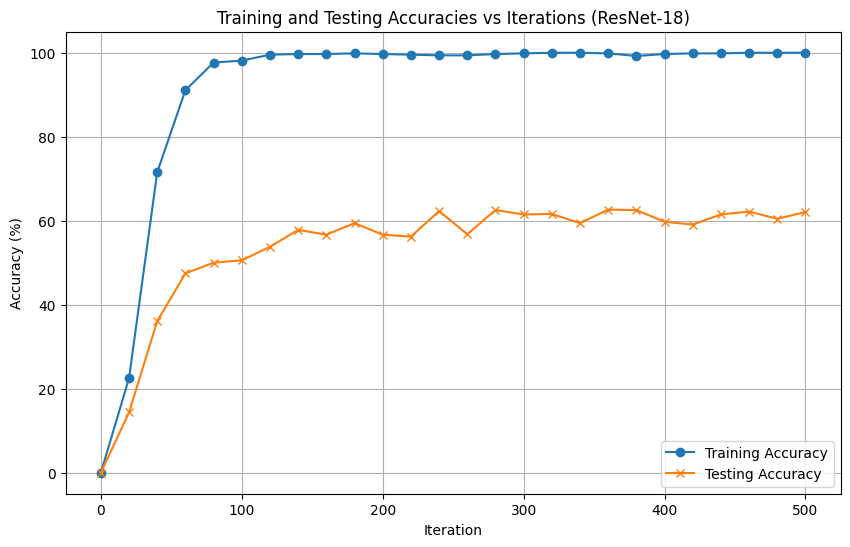

In [8]:
def plot_accuracies_vs_iterations(iterations, training_accuracies, testing_accuracies, save_path='accuracies_plot.png'):
    """
    Plot both training and testing accuracies against iterations and save the plot as an image.

    Parameters:
    - iterations: A list of iteration numbers.
    - training_accuracies: A list of training accuracies corresponding to the iterations.
    - testing_accuracies: A list of testing accuracies corresponding to the iterations.
    - save_path: Path and filename where the plot image will be saved. Default is 'accuracies_plot.png'.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, training_accuracies, label='Training Accuracy', marker='o')
    plt.plot(iterations, testing_accuracies, label='Testing Accuracy', marker='x')
    plt.title('Training and Testing Accuracies vs Iterations (ResNet-18)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    plt.savefig(save_path)
    
    # Now display the plot on screen
    plt.show()

# Extract data from the results variable
iterations = results["iterations"]
training_accuracies = results["training_accuracies"]
testing_accuracies = results["test_accuracies"]

# Specify the path and filename for saving the plot
save_path = 'accuracies_plot_ResNet18.png'

# Call the function with the extracted data and save path
plot_accuracies_vs_iterations(iterations, training_accuracies, testing_accuracies, save_path)



Confusion matrix:

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

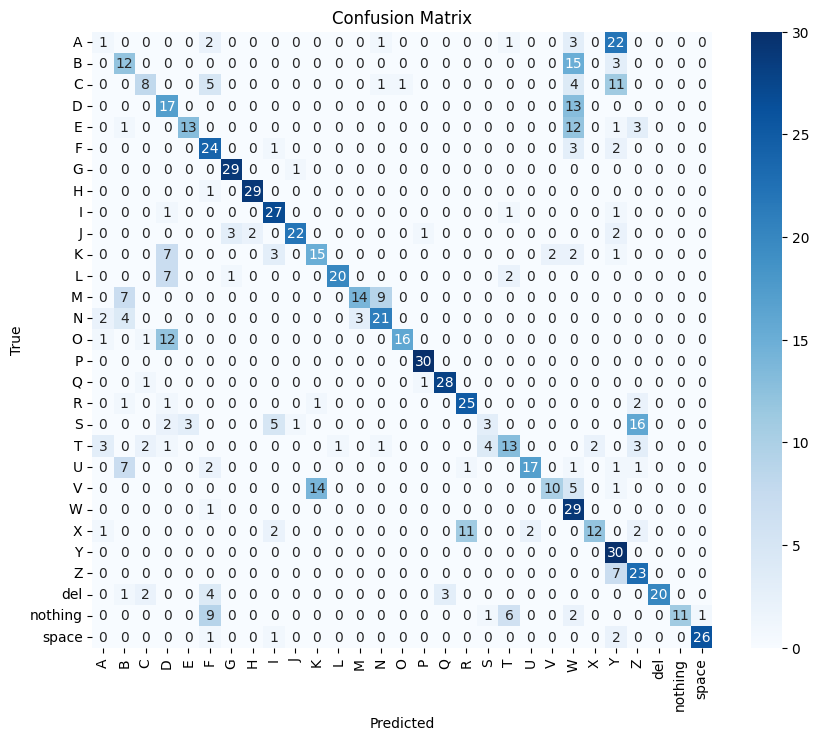

In [10]:
resnet_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy()) 
        true_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_ResNet18.png')
plt.show()


Demo:

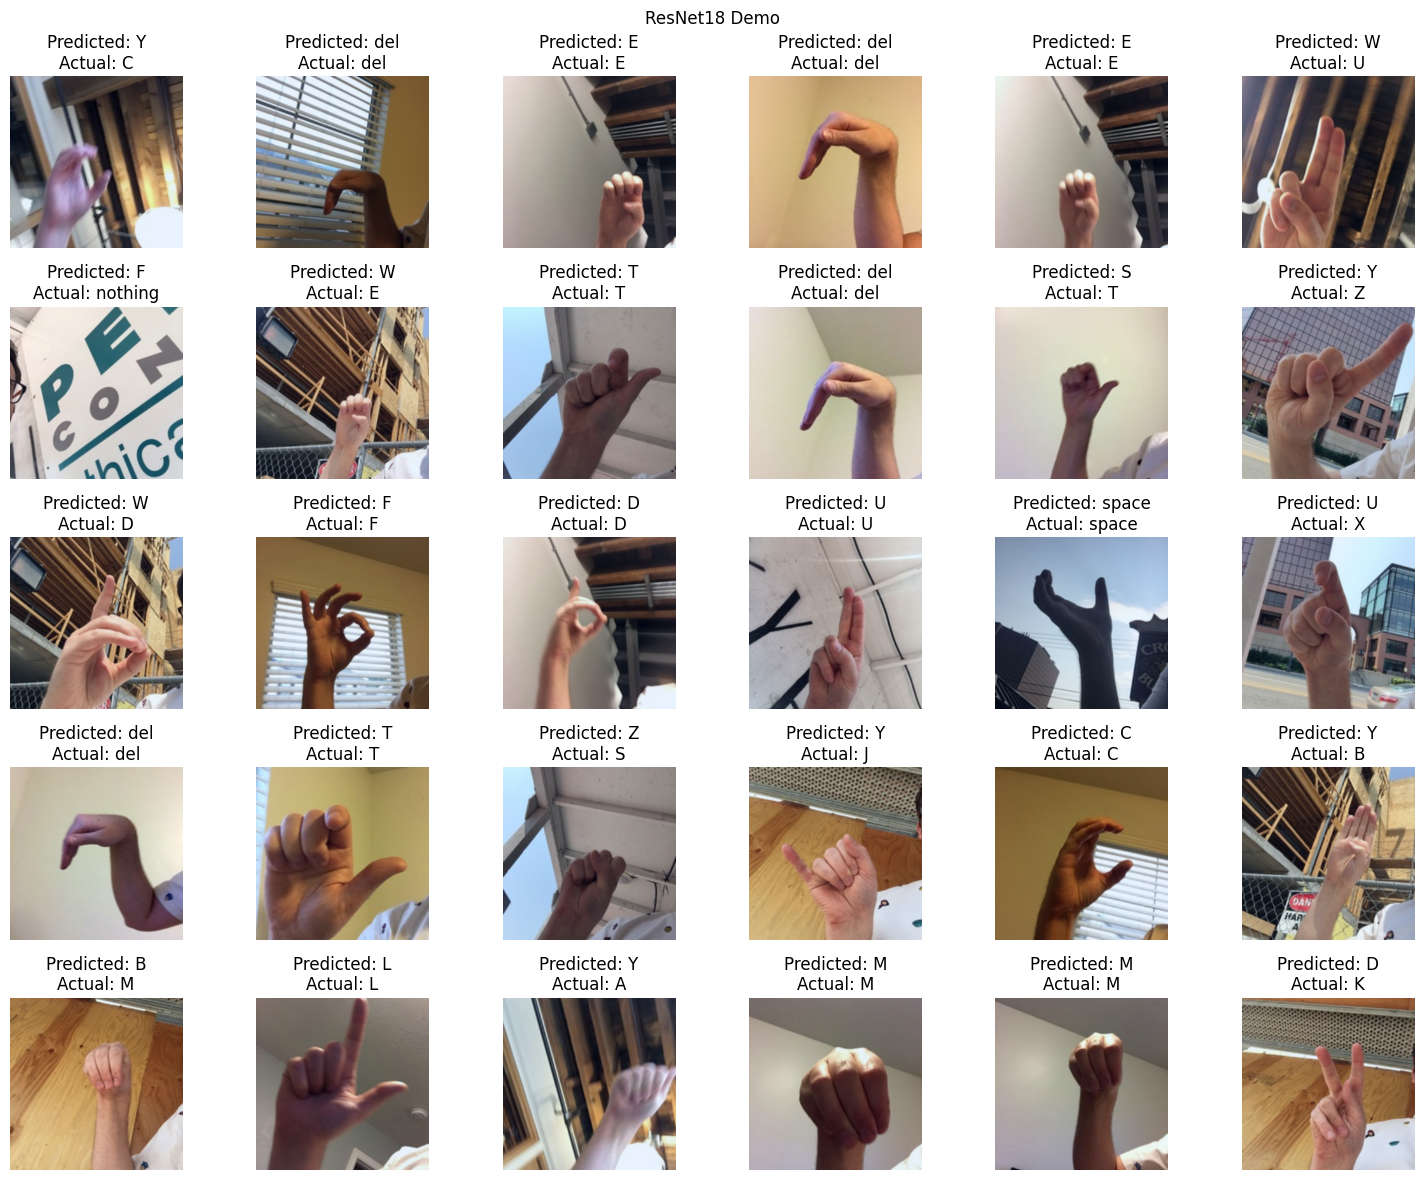

In [11]:
import random

resnet_model.eval()
random_indices = random.sample(range(len(test_dataset)), 30)
sampled_images = []
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i in random_indices:
        input, label = test_dataset[i]
        input = input.to(device).unsqueeze(0)         
        output = resnet_model(input)
        _, predicted = torch.max(output, 1)
        sampled_images.append(input.cpu().squeeze(0))  
        predicted_labels.append(predicted.item())
        actual_labels.append(label)

fig, axes = plt.subplots(5, 6, figsize=(15, 12))  
axes = axes.ravel()

for i, ax in enumerate(axes):
    img = np.transpose(sampled_images[i].cpu().numpy(), (1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax.imshow(img)
    ax.set_title(f'Predicted: {test_dataset.classes[predicted_labels[i]]}\nActual: {test_dataset.classes[actual_labels[i]]}')
    ax.axis('off')

fig.suptitle("ResNet18 Demo")
plt.tight_layout()
plt.savefig('demo_ResNet18.png')
plt.show()


## 2 Word Recognition

In [12]:
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 27.4 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.2 MB/s eta 0:00:00


In [13]:
from wordfreq import top_n_list

In [14]:
# Population
word_list = top_n_list('en', 1000)
# Test words
words = top_n_list('en', 100)

### 2.1 Test images generation

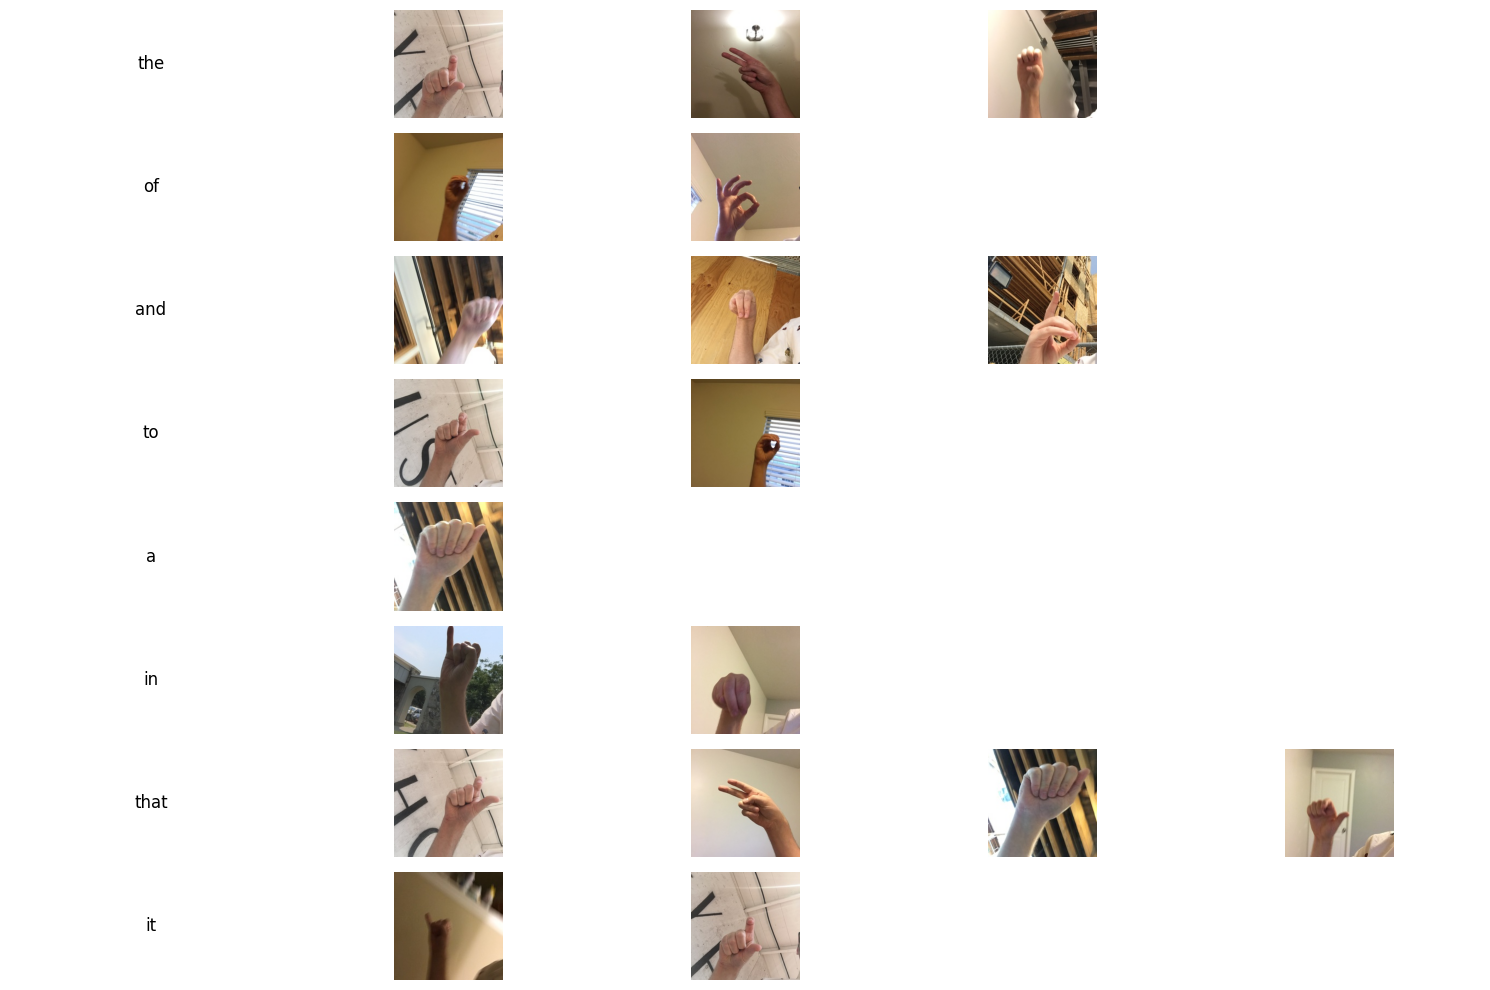

In [15]:
from IPython.display import display, Image

# Set base paths and common words
path_to_test# = '/kaggle/input/asl-alphabet-test/asl-alphabet-test'
words_demo = ["the", "of", "and", "to", "a", "in", "that", "it"]

# Function: Randomly select a picture from the folder with the specified letter
def random_image(letter):
    letter_path = os.path.join(path_to_test, letter)
    images = os.listdir(letter_path)
    random_image_filename = random.choice(images)
    return os.path.join(letter_path, random_image_filename)

# Generate a list of image paths for common words
selected_images = []
for word in words_demo:
    word_images = []
    for letter in word.upper():
        if letter.isalpha():  
            img_path = random_image(letter)
            word_images.append(img_path)
    selected_images.append(word_images)

# Calculate max number of columns
max_cols = max(map(len, selected_images))

# Assuming 'words_demo' contains your labels and 'selected_images' contains lists of image paths
max_cols = max(len(images) for images in selected_images) + 1  # Add one for the label column
fig, axes = plt.subplots(len(words_demo), max_cols, figsize=(15, 10), squeeze=False)

for row, word_images in enumerate(selected_images):
    # Set the label in the first column
    axes[row, 0].text(0.5, 0.5, words_demo[row], va='center', ha='center', fontsize=12, transform=axes[row, 0].transAxes)
    axes[row, 0].axis('off')  # Hide the frame and ticks

    # Display images in the subsequent columns
    for col in range(1, max_cols):  # Start from 1 to leave space for the label
        if col-1 < len(word_images):  # Adjust index for images
            img_path = word_images[col-1]  # Adjust index to access image
            img = plt.imread(img_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')  # Turn off unused axes

plt.tight_layout()
plt.show()



### 2.2 Word recognition without text analysis techniques

In [16]:
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function: Recognize letters in pictures
def recognize_image(image_path):
    image = Image.open(image_path) 
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = resnet_model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted

# The sequence of pictures generated for each word is recognized and compared with the original word
correct_count = 0
total_count = 0
errors = []

for word in words:
    recognized_letters = ''
    for letter in word.upper():
        if letter.isalpha():
            image_path = random_image(letter)
            predicted_letter = recognize_image(image_path)
            recognized_letters += chr(predicted_letter + ord('A'))
    
    if recognized_letters == word.upper():
        correct_count += 1
    else:
        errors.append((word, recognized_letters.lower()))
    
    total_count += 1


accuracy = (correct_count / total_count) * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Errors:', errors)

Accuracy: 16.00%
Errors: [('the', 'chw'), ('to', 'td'), ('and', 'abd'), ('of', 'df'), ('a', 'y'), ('is', 'iz'), ('for', 'foz'), ('that', 'xhyt'), ('on', 'ob'), ('with', 'widh'), ('this', 'thiz'), ('was', 'wyz'), ('be', 'by'), ('as', 'yz'), ('are', 'yre'), ('have', 'hnve'), ('at', 'yt'), ('he', 'hw'), ('not', 'ndx'), ('but', 'wuz'), ('or', 'dr'), ('we', 'ww'), ('an', 'yn'), ('your', 'yowr'), ('all', 'yll'), ('so', 'zo'), ('his', 'hij'), ('they', 'thwy'), ('me', 'mw'), ('if', 'iw'), ('one', 'dne'), ('can', 'yan'), ('will', 'wyll'), ('just', 'puet'), ('about', 'yydbt'), ('out', 'oua'), ('what', 'whyn'), ('has', 'hyz'), ('more', 'marw'), ('do', 'wo'), ('no', 'na'), ('were', 'wzzw'), ('had', 'hyw'), ("it's", 'itz'), ('their', 'zhwir'), ('there', 'zfwre'), ('her', 'hwz'), ('time', 'ndme'), ('been', 'bewn'), ('would', 'fdulw'), ('she', 'zhw'), ('new', 'nyw'), ('people', 'pedple'), ('how', 'hcf'), ("don't", 'ddnz'), ('some', 'eobz'), ('also', 'ytid'), ('them', 'ahen'), ('now', 'ndw'), ('other'

### 2.3 Word recognition with text analysis techniques

In [17]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


In [18]:
def find_closest_word(predicted_word, word_list):
    filtered_words = [word for word in word_list if len(word) == len(predicted_word)]
    closest_word = None
    min_distance = float('inf')
    for word in filtered_words:
        distance = levenshtein_distance(predicted_word, word)
        if distance < min_distance:
            min_distance = distance
            closest_word = word
    return closest_word



In [19]:
correct_count = 0
total_count = 0
errors = []

for word in words:
    recognized_letters = ''
    for letter in word.upper():
        if letter.isalpha():
            image_path = random_image(letter)
            predicted_letter = recognize_image(image_path)
            recognized_letters += chr(predicted_letter + ord('A'))
    
    closest_word = find_closest_word(recognized_letters.lower(), word_list)
    if closest_word == word.lower():
        correct_count += 1
    else:
        errors.append((word, closest_word))
    
    total_count += 1


accuracy = (correct_count / total_count) * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Errors:', errors)


Accuracy: 61.00%
Errors: [('is', 'in'), ('on', 'in'), ('as', 'to'), ('are', 'the'), ('at', 'to'), ('or', 'dr'), ('an', 'to'), ('all', 'old'), ('so', 'to'), ('me', 'be'), ('can', 'you'), ('will', 'find'), ('about', 'which'), ('out', 'due'), ('has', 'had'), ('do', 'we'), ('had', 'how'), ("it's", 'the'), ('get', 'was'), ('been', 'when'), ('would', 'words'), ('she', 'the'), ("don't", 'want'), ('some', 'just'), ('also', 'said'), ("i'm", 'do'), ('than', 'that'), ('know', 'your'), ('see', 'the'), ('two', 'and'), ('make', 'main'), ('then', 'when'), ('could', 'would'), ('back', 'ways'), ('these', 'three'), ('us', 'be'), ('want', 'word'), ('well', 'will'), ('said', 'know')]
